In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

In [3]:
filenames = [i for i in os.listdir('Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/') if i.endswith(".dat")]

In [ ]:
#lets have 23 for training and 7 for testing

In [4]:
data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[1]}', delimiter="\t", index_col = "sample")

In [ ]:
# #Information from andrew in the readme:
# 1. Motion profile (sine profile)

# max vel: 195.312 mm/s
# max acc/dec: 2500mm/s^2

# move distance: 0.5mm

# 2. Control BW: 50Hz with damping ratio 0.7

# 3. Objective: design a controller that could be used to compensate endpoint vibration (around 85hz)

# #column information from andrew:

# Notation about the datalog channel information as shown below:

# Sample è time indexing with sampling rate 8000           
# CMD_POS_FLOATMAG_BH      è Motion command
# ENC_POS_FLOATMAG_BH       è Encoder position
# POS_ERR_FLOATMAG_BH       è error between motion command and encoder
# DAC_FLOATMAG_BH                è Related to actuator electrical current
# FLOATMAG_ACC_ADC_PORT_0 è End point acceleration signal being measured with accelerometer

In [ ]:
#ok so the new data is slightly different

# - the encoder data is not in um but I assume we can convert using the same equation as previous:
#ENC_X(um) is calculated by ENC_POS_FLOATMAG_BH*5/1000

# - we no longer actually have endpoint position measurements, instead we have endpoint accelerometer meadurements
#ok so how do we want to proceed? Do we want to calculate position from acceleration as the reference values?
#or do we just want to predict the acceleration values?






In [55]:
data

,CMD_POS_FLOATMAG_BH,ENC_POS_FLOATMAG_BH,POS_ERR_FLOATMAG_BH,DAC_FLOATMAG_BH,MODE_FLOATMAG_BH,FLOATMAG_ACC_ADC_PORT_0
sample,,,,,,
0,-3.0,1.0,0.0,-205.0,ff010001,-223.0
1,-3.0,-3.0,0.0,-183.0,ff010001,41.0
2,-3.0,-1.0,-2.0,-204.0,903000a,-99.0
3,-3.0,1.0,-4.0,-198.0,903000a,131.0
4,-3.0,0.0,-3.0,-169.0,903000a,-96.0
...,...,...,...,...,...,...
13691,-3.0,-1.0,-2.0,-211.0,ff010001,24.0
13692,-3.0,-2.0,-1.0,-199.0,ff010001,64.0
13693,-3.0,-5.0,2.0,-188.0,ff010001,-6.0


In [ ]:
#so reached max position in around 0.06 seconds

Text(0.5, 0, 'Time (s)')

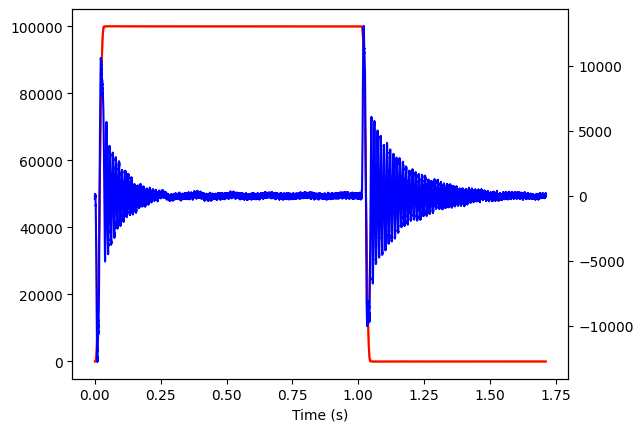

In [56]:
#plot of encoder position, command position, and endpoint acceleration vs time

#encoder position value of 1000000 is equivelent to 0.5 mm, (500um), so its a rise to 0.5 mm, a wait, and then a fall back to 0

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()


ax1.plot(data.index.values / 8000, data["ENC_POS_FLOATMAG_BH"].values, "orange", label = "ENC_POS_FLOATMAG_BH")
ax1.plot(data.index.values / 8000, data["CMD_POS_FLOATMAG_BH"].values, "r", label = "CMD_POS_FLOATMAG_BH")
ax2.plot(data.index.values / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values, "b", label = "FLOATMAG_ACC_ADC_PORT_0")


ax1.set_xlabel('Time (s)')



In [8]:
functional_point_velocity = (data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values

In [10]:
data["FLOATMAG_ACC_ADC_PORT_0"]

sample
0       -223.0
1         41.0
2        -99.0
3        131.0
4        -96.0
         ...  
13691     24.0
13692     64.0
13693     -6.0
13694    108.0
13695    173.0
Name: FLOATMAG_ACC_ADC_PORT_0, Length: 13696, dtype: float64

In [9]:
functional_point_position

sample
0         0.000000
1        -0.011375
2        -0.015000
3        -0.013000
4        -0.010812
           ...    
13691   -25.977812
13692   -25.972312
13693   -25.968687
13694   -25.962312
13695   -25.944750
Name: FLOATMAG_ACC_ADC_PORT_0, Length: 13696, dtype: float64

Text(0, 0.5, 'functional point position')

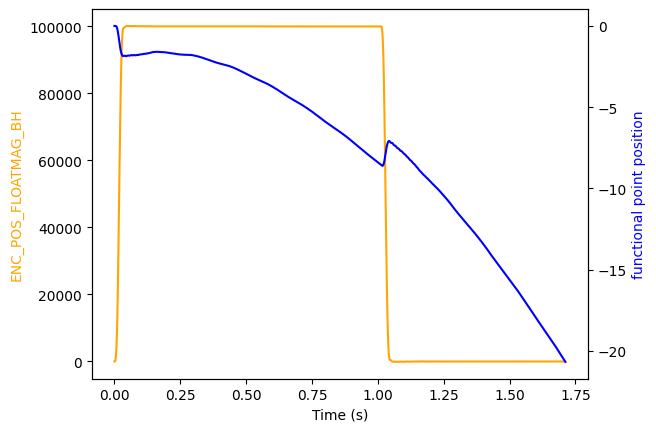

In [12]:
#plot of encoder position and endpoint position (by trapz integration of endpoint acceleration) vs time

#clearly a drift in the endpoint position, which is caused likely by sensor error
#so without some form of correction of this we are going to be unable to have a proper endpoint position reference

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

functional_point_velocity = (data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000))
functional_point_position = (functional_point_velocity).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values

ax1.plot(data.index.values / 8000, data["ENC_POS_FLOATMAG_BH"].values, "orange")
ax2.plot(data.index.values / 8000, functional_point_position, "b")



ax1.set_xlabel('Time (s)')
ax1.set_ylabel('ENC_POS_FLOATMAG_BH', color='orange')
ax2.set_ylabel('functional point position', color='b')


Text(0, 0.5, 'Functional point acceleration')

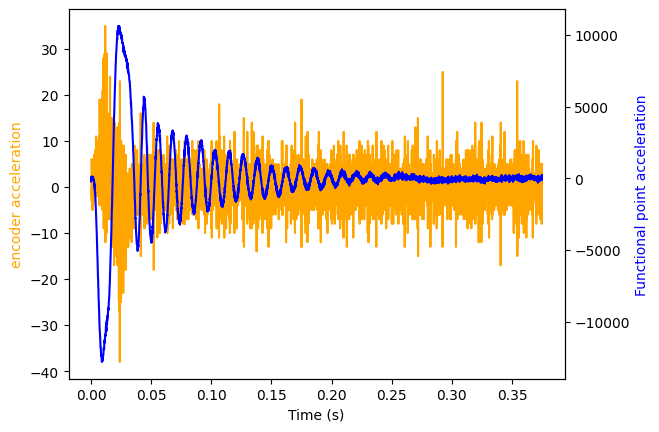

In [70]:
# plot of encoder acceleration and endpoint acceleration vs time

#

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

encoder_acceleration = data["ENC_POS_FLOATMAG_BH"].diff().diff()

ax1.plot(data.index.values[:3000] / 8000, encoder_acceleration.values[:3000], "orange")
ax2.plot(data.index.values[:3000] / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values[:3000], "b")


ax1.set_xlabel('Time (s)')
ax1.set_ylabel('encoder acceleration', color='orange')
ax2.set_ylabel('Functional point acceleration', color='b')


Text(0, 0.5, 'functional point position')

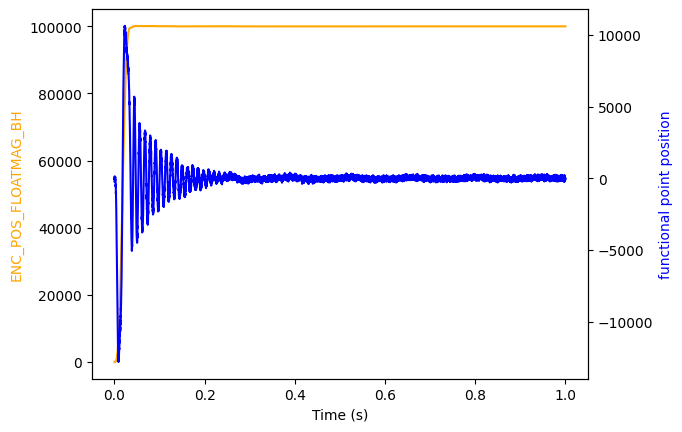

In [81]:
#lets get a closer view of the data:

#so a time range of 0.05 is all it takes for the current motion profile to reach the max position from start
time_range = 1


fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

functional_point_position = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values

ax1.plot(data.index.values[:int(time_range * 8000)] / 8000, data["ENC_POS_FLOATMAG_BH"].values[:int(time_range * 8000)], "orange")
ax2.plot(data.index.values[:int(time_range * 8000)] / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values[:int(time_range * 8000)], "b")



ax1.set_xlabel('Time (s)')
ax1.set_ylabel('ENC_POS_FLOATMAG_BH', color='orange')
ax2.set_ylabel('functional point position', color='b')

In [82]:
0.4 * 8000

3200.0

Text(0, 0.5, 'functional point position')

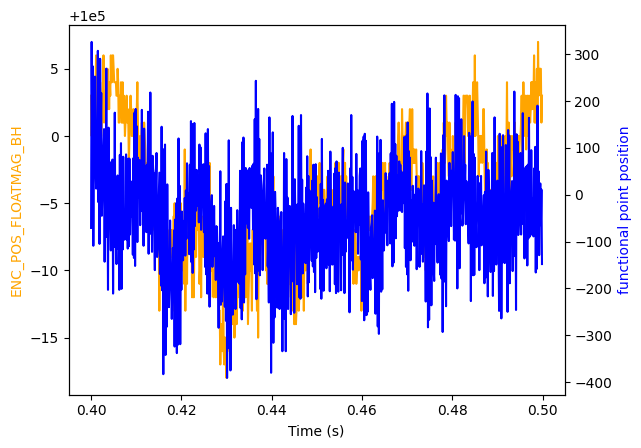

In [84]:
#wanted a view of the data from 0.4 to 0.5 seconds
#basically all of the data is relevant, dont have to segment the datasets

fix, ax1 = plt.subplots()

ax2 = ax1.twinx()

functional_point_position = (-data["FLOATMAG_ACC_ADC_PORT_0"]).expanding().apply(lambda x: np.trapz(x, dx=1/8000)).values

ax1.plot(data.index.values[3200:4000] / 8000, data["ENC_POS_FLOATMAG_BH"].values[3200:4000], "orange")
ax2.plot(data.index.values[3200:4000] / 8000, data["FLOATMAG_ACC_ADC_PORT_0"].values[3200:4000], "b")



ax1.set_xlabel('Time (s)')
ax1.set_ylabel('ENC_POS_FLOATMAG_BH', color='orange')
ax2.set_ylabel('functional point position', color='b')

In [10]:
24/ 30

0.8

In [12]:
import os
import pandas as pd

#30 total
#24 for training
#6 for testing

filenames = [i for i in os.listdir('Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/') if i.endswith(".dat")]

train_data = pd.DataFrame()

for i in range(24):

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t")

    data["dENC_X"] = data["ENC_POS_FLOATMAG_BH"].diff()
    data["ddENC_X"] = data["dENC_X"].diff()

    t_data = data[["sample", "ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "FLOATMAG_ACC_ADC_PORT_0", "DAC_FLOATMAG_BH"]]
    t_data["file"] = i

    train_data = pd.concat([train_data, t_data])



test_data = pd.DataFrame()

for i in range(24, 30):

    data = pd.read_csv(f'Data/FLOATMAG_BH_Datalog_2023_10_17 09.37.30 _Samp=8000/{filenames[i]}', delimiter="\t")

    data["dENC_X"] = data["ENC_POS_FLOATMAG_BH"].diff()
    data["ddENC_X"] = data["dENC_X"].diff()

    t_data = data[["sample", "ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "FLOATMAG_ACC_ADC_PORT_0", "DAC_FLOATMAG_BH"]]
    t_data["file"] = i

    test_data = pd.concat([test_data, t_data])


train_data.to_csv("Data/train_data_new.csv", index = False)
test_data.to_csv("Data/test_data_new.csv", index = False)



    

C:\Users\Chirag\AppData\Local\Temp\ipykernel_26932\73914936.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_data["file"] = i
C:\Users\Chirag\AppData\Local\Temp\ipykernel_26932\73914936.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_data["file"] = i
C:\Users\Chirag\AppData\Local\Temp\ipykernel_26932\73914936.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
#ok so in order to achieve the projects objective we need to provide the dac signal that corrects for the endpoint vibrations

#questions:
#We only have endpoint acceleration, and I am not sure that by numerical integration, the endpoint position is accurate
#Given this, we are going to just try and predict the acceleration values for now.
#Ok so how do we go from predicted acceleration values to a dac signal?

#first thing is to figure out how off from the desired point the endpoint is. But what do we use as the reference for this? ie in a real situation, lets say we have our predicted endpoint acceleration, what do we compare this to?
#Ok assuming we have some sort of desired endpoint position/ acceleration, and we have a prediction of the actual position / acceleration, what do we do:
# - we need some sort of dac reference, how do we convert measurement error differences into dac signal? We need information on this
# - also currently what are the units for all of the columns? encoder position we know from before, but what about the acceleration and dac signal?

